<a href="https://colab.research.google.com/github/ianimeshjain/Image_Similarity_Finder_Knn_Kmeans_Machine_Learning/blob/main/Image_Similarity_K-means_knn_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# For array manipulation
import numpy as np
import pandas as pd
import pandas.util.testing as tm
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
from sklearn.externals import *
#For model training


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

In [ ]:
! pip install DeepImageSearch -q
from DeepImageSearch import Index,LoadData,SearchImage
file_path = LoadData().from_folder(folder_list = ['/content/images'])
print(len(file_path))

     |████████████████████████████████| 646 kB 10.3 MB/s 
     |████████████████████████████████| 462 kB 37.7 MB/s 
12


In [ ]:
train_files, test_files = train_test_split(file_path, test_size = 0.15)
print(len(train_files))
print(len(test_files))

train_files = pd.DataFrame(train_files,columns=['filepath'])
test_files = pd.DataFrame(test_files,columns=['filepath'])
train_files.to_csv('/content/train_file.csv')
test_files.to_csv('/content/test_file.csv')

10
2


In [ ]:
train_files = list(pd.read_csv('/content/train_file.csv')['filepath'])
test_files = list(pd.read_csv('/content/test_file.csv')['filepath'])

In [ ]:
def image2array(file_array):

    """
    Reading and Converting images into numpy array by taking path of images.
    Arguments:
    file_array - (list) - list of file(path) names
    Returns:
    A numpy array of images. (np.ndarray)
    """

    image_array = []
    for path in tqdm(file_array):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(np.array(img))
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3) 
    image_array = image_array.astype('float32')
    image_array /= 255 
    return np.array(image_array)

In [ ]:
train_data = image2array(train_files)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files)
print("Length of test dataset:",test_data.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

Length of training dataset: (10, 224, 224, 3)


  0%|          | 0/2 [00:00<?, ?it/s]

Length of test dataset: (2, 224, 224, 3)


In [ ]:
def encoder_decoder_model():

    """
    Used to build Convolutional Autoencoder model architecture to get compressed image data which is easier to process.
    Returns:
    Auto encoder model
    """
    #Encoder 
    model = Sequential(name='Convolutional_AutoEncoder_Model')
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 3),padding='same', name='Encoding_Conv2D_1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
    model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
    
    #Decoder
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_1'))
    model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
    model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_2'))
    model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_3'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
    model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_5'))
    model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='Decoding_Output'))
    return model

Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoding_Conv2D_1 (Conv2D)  (None, 224, 224, 64)      1792      
                                                                 
 Encoding_MaxPooling2D_1 (Ma  (None, 112, 112, 64)     0         
 xPooling2D)                                                     
                                                                 
 Encoding_Conv2D_2 (Conv2D)  (None, 112, 112, 128)     73856     
                                                                 
 Encoding_MaxPooling2D_2 (Ma  (None, 56, 56, 128)      0         
 xPooling2D)                                                     
                                                                 
 Encoding_Conv2D_3 (Conv2D)  (None, 56, 56, 256)       295168    
                                                                 
 Encoding_MaxPooling2D_3 (Ma  (None

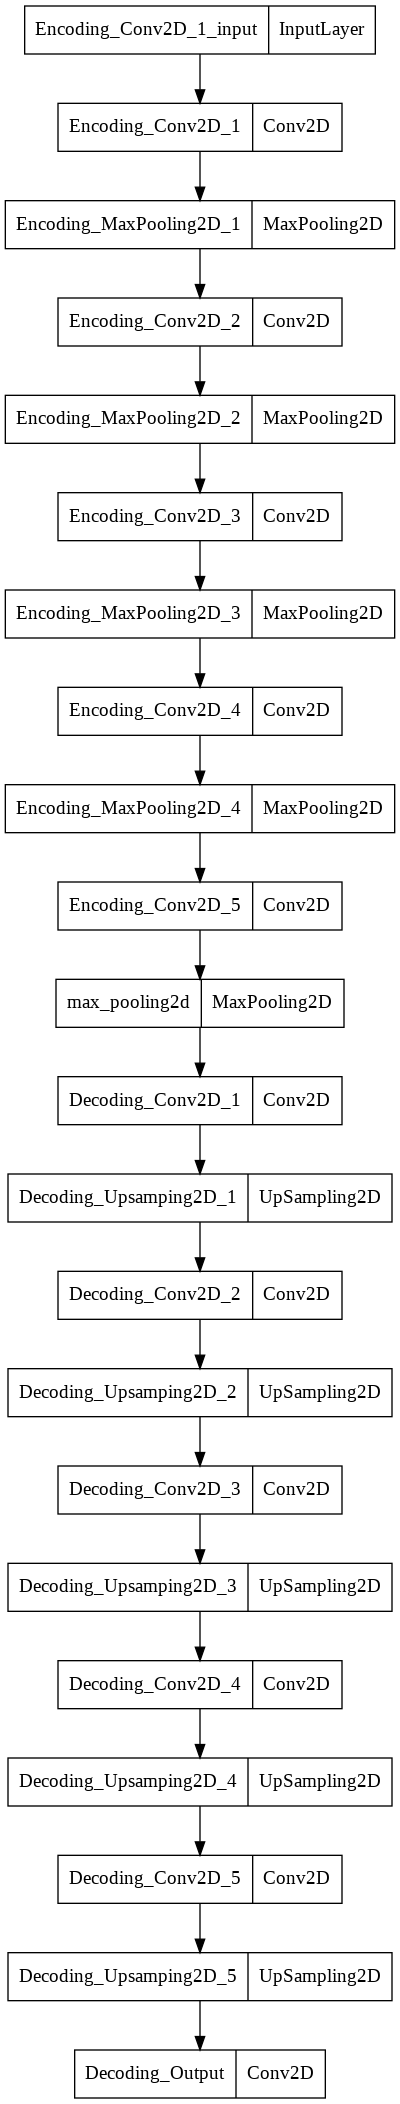

In [ ]:
model = encoder_decoder_model()
model.summary()
print("\n")
tf.keras.utils.plot_model(model, to_file='/content/model/model.png')

In [ ]:
parameters = {'Adagrad':[0.01,0.001,0.0001,0.00001],'Adam':[0.01,0.001,0.0001,0.00001],'Rmsprop':[0.01,0.001,0.0001,0.00001]}
result = []
for i in parameters.keys():
    print("{} as an optimizer:".format(i))
    values = parameters[i]
    result_ = []
    for learning_rate in values:
        print("\t\tUsing learning_rate: "+str(learning_rate))
        model = encoder_decoder_model()
        if i=='Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif i=='Adagrad':
            optimizer = Adagrad(learning_rate=learning_rate)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')             # compiling 
        model.fit(train_data, train_data, epochs=5, batch_size=32,validation_data=(test_data,test_data))  # fitting data
        result_.append(model.history.history)           # taking result to judge the best parameters.
    print()
    result.append(result_)

Adagrad as an optimizer:
		Using learning_rate: 0.01
Epoch 1/5
1/1 [==============================] - 23s 23s/step - loss: 2.3982 - val_loss: 2.4181
Epoch 2/5
1/1 [==============================] - 20s 20s/step - loss: 2.3978 - val_loss: 2.4178
Epoch 3/5
1/1 [==============================] - 19s 19s/step - loss: 2.3975 - val_loss: 2.4175
Epoch 4/5
1/1 [==============================] - 13s 13s/step - loss: 2.3972 - val_loss: 2.4172
Epoch 5/5
1/1 [==============================] - 12s 12s/step - loss: 2.3969 - val_loss: 2.4169
		Using learning_rate: 0.001
Epoch 1/5
1/1 [==============================] - 13s 13s/step - loss: 2.3991 - val_loss: 2.4194
Epoch 2/5
1/1 [==============================] - 11s 11s/step - loss: 2.3990 - val_loss: 2.4194
Epoch 3/5
1/1 [==============================] - 11s 11s/step - loss: 2.3990 - val_loss: 2.4193
Epoch 4/5
1/1 [==============================] - 11s 11s/step - loss: 2.3990 - val_loss: 2.4193
Epoch 5/5
1/1 [==============================] - 11s 1

In [ ]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

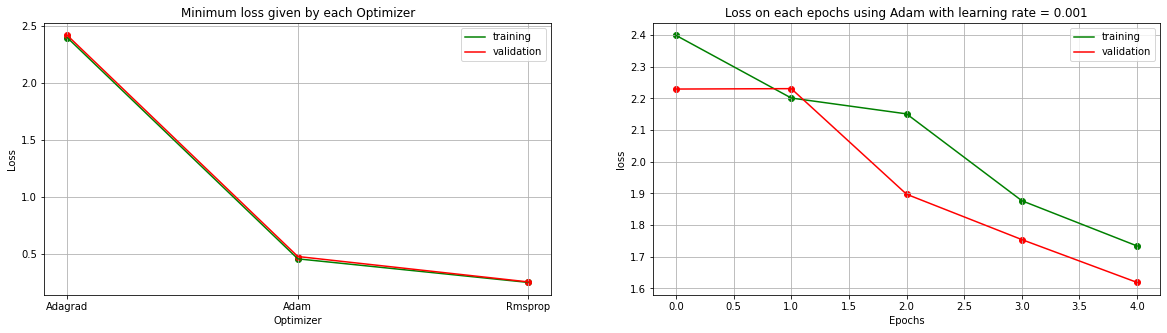

In [ ]:
min_train = []; min_val = []  
rates = list(parameters.keys())
epochs = [0,1,2,3,4]
for i in result:
    train = []; val = []
    for j in i:
        train.append(min(j['loss'])); val.append(min(j['val_loss']))  # taking minimum loss of each optimizer over all learning rates.
    min_train.append(min(train)); min_val.append(min(val))
plt.figure(figsize=(20,5))
plot_(rates,min_train,min_val,1,2,1,'Minimum loss given by each Optimizer','Optimizer','Loss','training',False,'r')
# plotting the result of adam with learning rate = 0.001 .
plot_(epochs, result[1][1]['loss'],result[1][1]['val_loss'],1,2,2,'Loss on each epochs using Adam with learning rate = 0.001','Epochs','loss','training',False,'r')
plt.show()

In [ ]:
optimizer = Adam(learning_rate=0.001) 
model = encoder_decoder_model() 
model.compile(optimizer=optimizer, loss='mse') 
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.0001) 
checkpoint = ModelCheckpoint('/content/model/encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_data, train_data, epochs=35, batch_size=32,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint]) 

Epoch 1/35
1/1 [==============================] - 14s 14s/step - loss: 2.3977 - val_loss: 2.2228
Epoch 2/35
1/1 [==============================] - 12s 12s/step - loss: 2.1971 - val_loss: 2.2526
Epoch 3/35
1/1 [==============================] - 12s 12s/step - loss: 2.1666 - val_loss: 1.8965
Epoch 4/35
1/1 [==============================] - 14s 14s/step - loss: 1.8776 - val_loss: 1.7524
Epoch 5/35
1/1 [==============================] - 12s 12s/step - loss: 1.7324 - val_loss: 1.6180
Epoch 6/35
1/1 [==============================] - 12s 12s/step - loss: 1.5978 - val_loss: 1.4924
Epoch 7/35
1/1 [==============================] - 11s 11s/step - loss: 1.4717 - val_loss: 1.3753
Epoch 8/35
1/1 [==============================] - 12s 12s/step - loss: 1.3543 - val_loss: 1.2668
Epoch 9/35
1/1 [==============================] - 12s 12s/step - loss: 1.2451 - val_loss: 1.1668
Epoch 10/35
1/1 [==============================] - 12s 12s/step - loss: 1.1429 - val_loss: 1.0811
Epoch 11/35
1/1 [============

In [ ]:
model = load_model("/content/model/encoder_model.h5")
model.compile(optimizer=optimizer, loss='mse') 

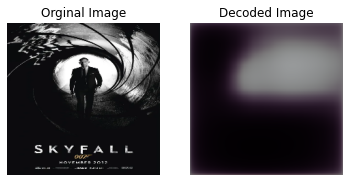

In [ ]:
sample_image = train_data[1]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)
plot_(sample_image[0,:,:,:],'','',1,2,1,"Orginal Image","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded Image","","","",True)
plt.show()

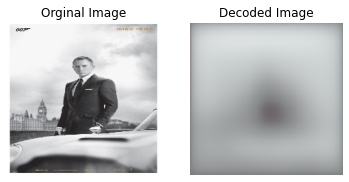

In [ ]:
sample_image = train_data[4]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)
plot_(sample_image[0,:,:,:],'','',1,2,1,"Orginal Image","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded Image","","","",True)
plt.show()

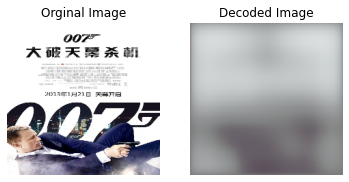

In [ ]:
model = load_model('/content/model/encoder_model.h5')
sample_image = train_data[2]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)
plot_(train_data[2],'','',1,2,1,"Orginal Image","","","",True)
plot_(image[0,:,:],'','',1,2,2,"Decoded Image","","","",True)
plt.show()

In [ ]:
from keras import backend as K
def feature_extraction(model, data, layer = 4):

    """
    Creating a function to run the initial layers of the encoder model. (to get feature extraction from any layer of the model)
    Arguments:
    model - (Auto encoder model) - Trained model
    data - (np.ndarray) - list of images to get feature extraction from trained model
    layer - (int) - from which layer to take the features(by default = 4)
    Returns:
    pooled_array - (np.ndarray) - array of extracted features of given images
    """

    encoded = K.function([model.layers[0].input],[model.layers[layer].output])
    encoded_array = encoded([data])[0]
    pooled_array = encoded_array.max(axis=-1)
    return encoded_array
encoded = feature_extraction(model,train_data[:10],12)

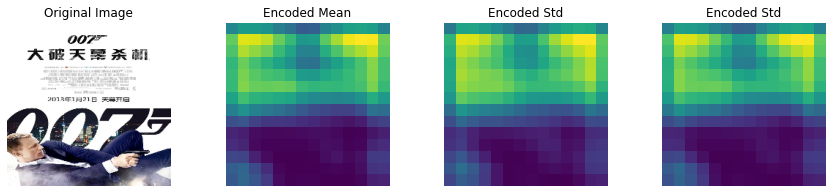

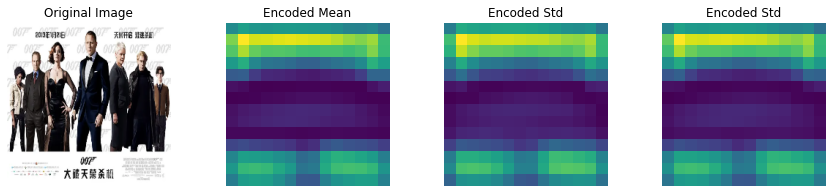

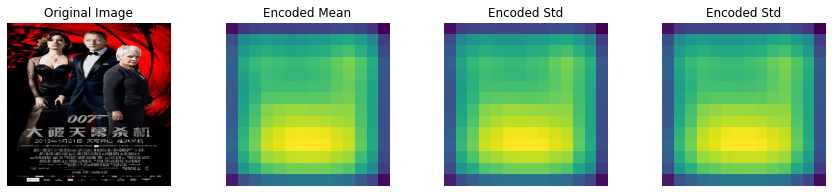

In [ ]:
for index in [2,7,9]:   # 3 random images
    plt.figure(figsize=(15,3))
    plot_(train_data[index],'','',1,4,1,"Original Image","","",'',True)
    plot_(encoded[index].mean(axis=-1),'','',1,4,2,"Encoded Mean","","",'',True)
    plot_(encoded[index].max(axis=-1),'','',1,4,3,"Encoded Std","","",'',True)
    plot_(encoded[index].std(axis=-1),'','',1,4,4,"Encoded Std","","",'',True)
    plt.show()

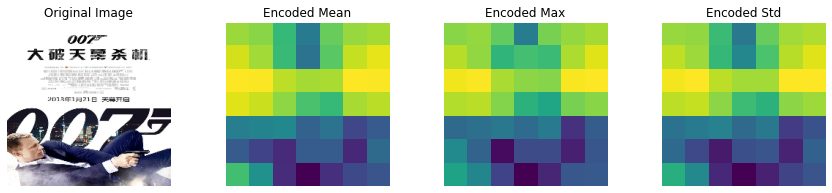

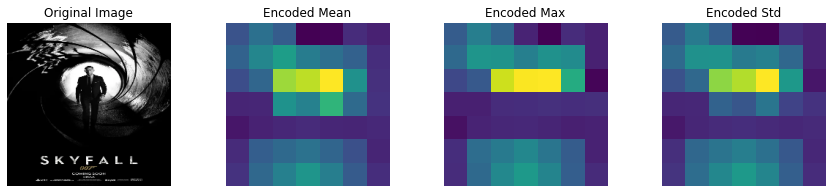

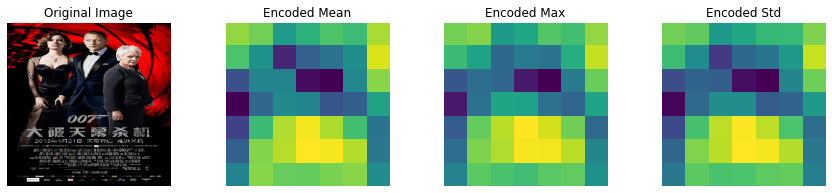

In [ ]:
encoded = feature_extraction(model,train_data[:10],9)
for index in [2,6,9]:   # 3 random images
    plt.figure(figsize=(15,3))
    plot_(train_data[index],'','',1,4,1,"Original Image","","",'',True)
    plot_(encoded[index].mean(axis=-1),'','',1,4,2,"Encoded Mean","","",'',True)
    plot_(encoded[index].max(axis=-1),'','',1,4,3,"Encoded Max","","",'',True)
    plot_(encoded[index].std(axis=-1),'','',1,4,4,"Encoded Std","","",'',True)
    plt.show()

In [ ]:
def get_batches(data, batch_size=1000):

    """
    Taking batch of images for extraction of images.
    Arguments:
    data - (np.ndarray or list) - list of image array to get extracted features.
    batch_size - (int) - Number of images per each batch
    Returns:
    list - extracted features of each images
    """

    if len(data) < batch_size:
        return [data]
    n_batches = len(data) // batch_size
    
    # If batches fit exactly into the size of df.
    if len(data) % batch_size == 0:
        return [data[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]   

    # If there is a remainder.
    else:
        return [data[i*batch_size:min((i+1)*batch_size, len(data))] for i in range(n_batches+1)]

In [ ]:
d = np.concatenate([train_data,test_data],axis=0)
d.shape

(12, 224, 224, 3)

In [ ]:
X_encoded = []
i=0
# Iterate through the full training set.
for batch in get_batches(d, batch_size=300):
    i+=1
    # This line runs our pooling function on the model for each batch.
    X_encoded.append(feature_extraction(model, batch))
    
X_encoded = np.concatenate(X_encoded)

In [ ]:
X_encoded.shape 

(12, 56, 56, 256)

In [ ]:
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2]*X_encoded.shape[3])
print('Encoded shape:', X_encoded_reshape.shape)
np.save('/content/X_encoded_compressed.npy',X_encoded_reshape)

Encoded shape: (12, 802816)


In [ ]:
X_encoded = np.load('/content/X_encoded_compressed.npy')
X_encoded.shape

(12, 802816)

In [ ]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

12


In [ ]:
transform = TSNE 
trans = transform(n_components=2) 
values = trans.fit_transform(X_encoded_reshape) 

In [ ]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='b'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot 
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

In [ ]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

14


if Number of clusters: 4


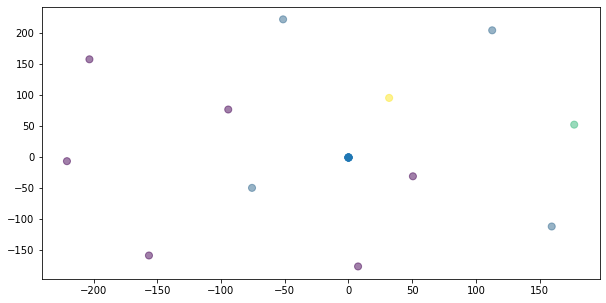

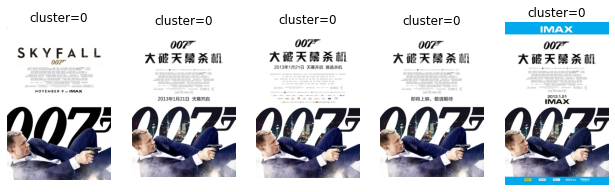

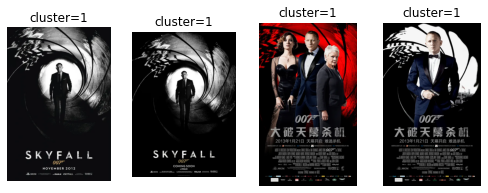

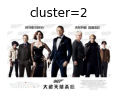

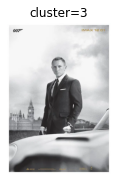


if Number of clusters: 5


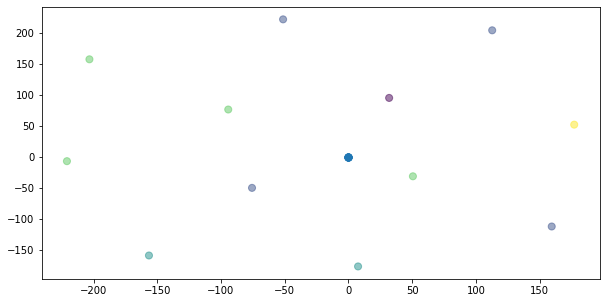

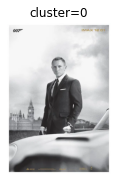

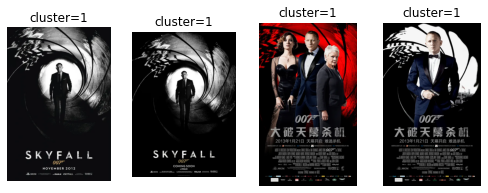

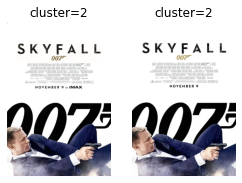

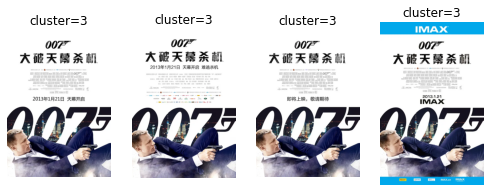

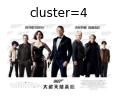


if Number of clusters: 6


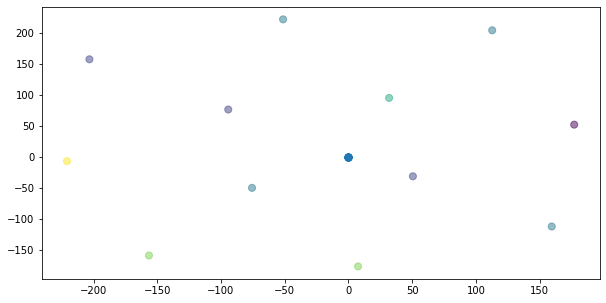

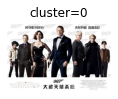

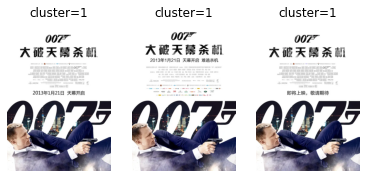

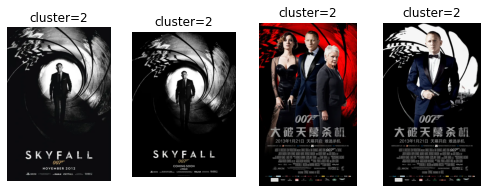

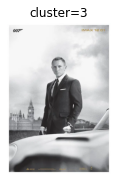

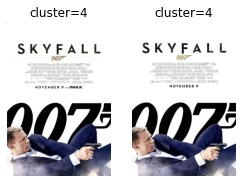

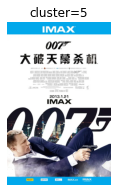


if Number of clusters: 7


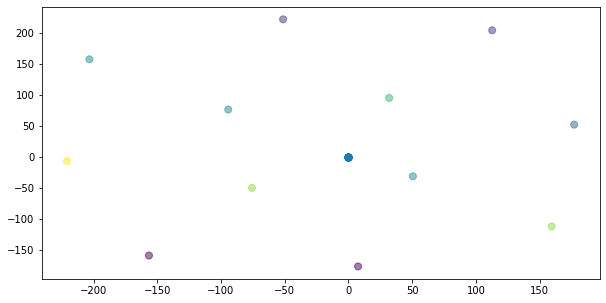

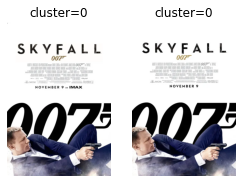

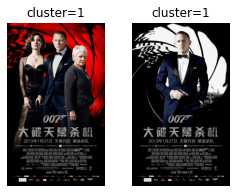

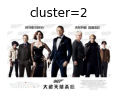

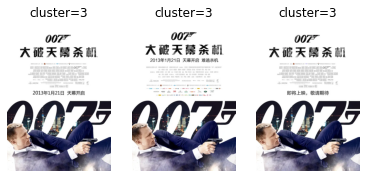

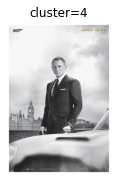

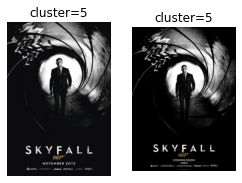

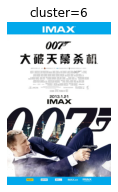

In [ ]:
K = [4,5,6,7]
for k in K:
    print("if Number of clusters: "+str(k))
    kmeans = KMeans(n_clusters = k, random_state=0).fit(X_encoded_reshape)
    labels=kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,1,1)
    plt.scatter(values[:,0], values[:,1], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=None, s=50)
    plt.show()
    for row in range(k): 
        iter=0
        plt.figure(figsize=(13,3))
        for i,iterator in enumerate(labels):
            if iterator == row:
                img = cv2.imread(lisp[i])
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                plot_(img,"","",1,6,iter+1,"cluster="+str(row),"","","",True)
                iter+=1
            if iter>=5: break
        plt.show()
    print() 

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state=0).fit(X_encoded_reshape)
labels=kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
pip install joblib

In [ ]:
import joblib

In [ ]:
kmeans_file = '/content/knnModel/kmeans_model.pkl'
joblib.dump(kmeans,kmeans_file)

['/content/knnModel/kmeans_model.pkl']

In [ ]:
clusters_features = []
cluster_files=[]
for i in [0,1,2,3,4,5]:
    i_cluster = []
    i_labels=[]
    for iter,j in enumerate(kmeans.labels_):
        if j==i:
            i_cluster.append(X_encoded_reshape[iter])
            i_labels.append(lisp[iter])
    i_cluster = np.array(i_cluster)
    clusters_features.append(i_cluster)
    cluster_files.append(i_labels)

In [ ]:
labels=[]
data=[]
files=[]
for iter,i in enumerate(clusters_features):
    data.extend(i)
    labels.extend([iter for i in range(i.shape[0])])
    files.extend(cluster_files[iter])
print(np.array(labels).shape)
print(np.array(data).shape)
print(np.array(files).shape)

(12,)
(12, 802816)
(12,)


In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
for i in [[3,5,7],[9,11,13]]:
    plt.figure(figsize=(25,5))
    for iter,j in enumerate(i):
        n_neighbors = j
        X = values  
        y = labels
        h = .09  # step size in the mesh
        cmap_light = ListedColormap(['#FFB6C1', '#AAFFAA', '#AAAAFF','#E6E6FA','#8FBC8F','#DCDCDC'])
        cmap_bold = ListedColormap(['#F08080', '#00FF00', '#0000FF','#ADD8E6','#2F4F4F','#808080'])
        clf = KNeighborsClassifier(n_neighbors)
        clf.fit(X, y)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        plt.subplot(1,3,iter+1)
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points 
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("For K = {} as neighbors".format(j))
    plt.show()  

KeyboardInterrupt: ignored

<Figure size 1800x360 with 0 Axes>

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='ball_tree',n_jobs=-1)
knn.fit(np.array(data),np.array(labels))

KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=9)

In [ ]:
knn_file = '/content/knn/knn_model.pkl'
joblib.dump(knn,knn_file)

['/content/knn/knn_model.pkl']

In [ ]:
def results_(query,result):
    
    """
    Plotting the N similar images from the dataset with query image.
    Arguments:
    query - (string) - filename of the query image
    result - (list) - filenames of similar images
    """

    def read(img):
        image = cv2.imread(img)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return image
    plt.figure(figsize=(10,5))
    if type(query)!=type(30):
        plot_(query,"","",1,1,1,"Query Image","","","",True)
    else:
        plot_(read(files[query]),"","",1,1,1,"Query Image "+files[query],"","","",True)
    plt.show()
    plt.figure(figsize=(20,5))
    for iter,i in enumerate(result):
        plot_(read(files[i]),"","",1,len(result),iter+1,files[i],"","","",True)
    plt.show()

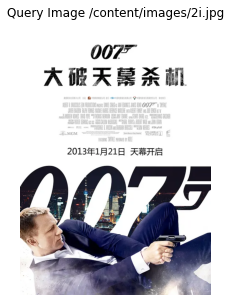

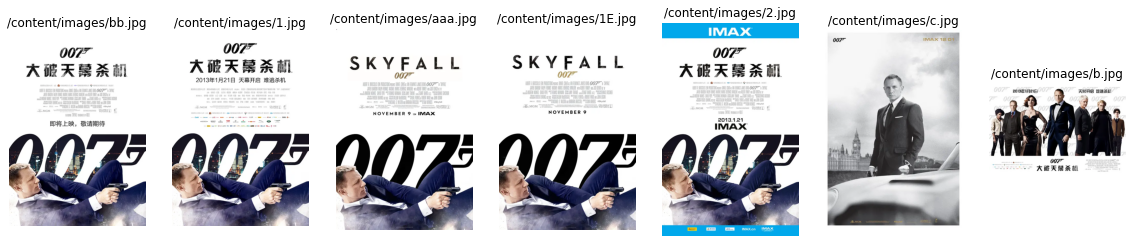

In [ ]:
num = 1 #datapoint
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=8)
results_(num,list(res[1][0])[1:])

In [ ]:
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

In [ ]:

def predictions(label,N=5,isurl=False):

    """
    Making predictions for the query images and returns N similar images from the dataset.
    We can either pass filename or the url for the image.
    Arguments:
    label - (string) - file name of the query image.
    N - (int) - Number of images to be returned
    isurl - (string) - if query image is from google is set to True else False(By default = False)
    """

    if isurl:
        img = io.imread(label)
        img = cv2.resize(img,(224,224))
    else:
        img_path = label
        img = image.load_img(img_path, target_size=(224,224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data,axis=0)
    img_data = preprocess_input(img_data)
    feature = K.function([model.layers[0].input],[model.layers[12].output])
    feature = np.array(feature).flatten().reshape(1,-1)
    res = knn.kneighbors(return_distance=True,n_neighbors=N)
    results_(img,list(res[1][0])[1:])

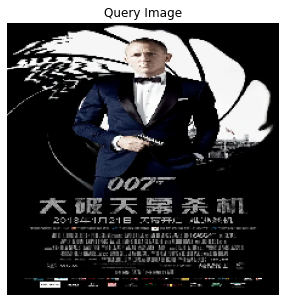

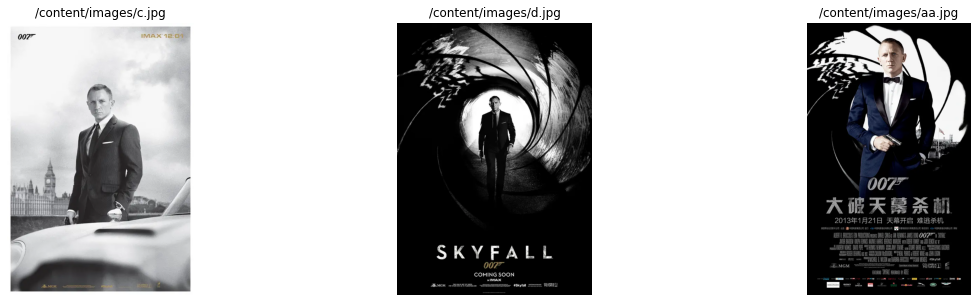

In [ ]:
query_path = 'images/aa.jpg'
predictions(query_path,4)